# Capstone-Project-aiml
## AIML Online Capstone - Pneumonia Detection Challenge
### Project Objectives
The objective of the project is,  Learn to how to do build an Object Detection Model  Use transfer learning to fine-tune a model.  Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.  Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.

## The Real Problem
### What is Pneumonia?
Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017, 920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or postradiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis. CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift. Pneumonia Detection Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

### Business Domain Value
Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

### Project Description
In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images:

Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. Details about the data and dataset files are given in below link, https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

#### Pre-Processing, Data Visualization, EDA
 Exploring the given Data files, classes and images of different classes.  Dealing with missing values  Visualization of different classes  Analysis from the visualization of different classes.

#### Model Building
 Building a pneumonia detection model starting from basic CNN and then improving upon it.  Train the model  To deal with large training time, save the weights so that you can use them when training the model for the second time without starting from scratch.

#### Test the Model, Fine-tuning and Repeat
 Test the model and report as per evaluation metrics  Try different models  Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc. for these models to fine-tune them  Report evaluation metrics for these models along with your observation on how changing different hyper parameters leads to change in the final evaluation metric.

### Reference
Acknowledgment for the datasets. https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements

In [1]:
!pip install tensorflow==1.15
!pip install tensorflow-gpu==1.15
!pip install keras==2.2.4
!pip install pydicom

In [ ]:
!git clone https://github.com/WittmannF/LRFinder.git

In [2]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [3]:
import random
random.seed(0)
import warnings
warnings.filterwarnings('ignore')

Installing pydicom

In [4]:
import os
import pandas as pd
import pydicom as dcm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tqdm.notebook as tq
from copy import deepcopy
import glob
import datetime
import cv2
import pytz
import multiprocessing
import hashlib
from sklearn.utils import shuffle
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

%matplotlib inline 

In [69]:
import importlib
from LRFinder.keras_callback import LRFinder

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Install kaggle to download the dataset
!pip install -q kaggle

### Setting up kaggle to download datasets

- Please setup the kaggle_path where you have kept the kaggle.json file
- Or create the directory structure in your google drive like MyDrive/Colab/.kaggle/ and upload kaggle.json to this location

In [7]:
# Ensure you have setup kaggle.json with the required API token and saved it to your google drive mounted above.
# Provide the location of the .kaggle/kagle.json file
kaggle_path = '/content/drive/MyDrive/Colab/.kaggle/'
os.chdir(kaggle_path)
#!export KAGGLE_CONFIG_DIR=/content/drive/MyDrive/Colab/.kaggle/

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle --version

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Kaggle API 1.5.12


In [8]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [9]:
# Kaggle api version should be 1.5.12 or higher
!kaggle --version

Kaggle API 1.5.12


### Download datasets from kaggle
- Please setup the destination path where you want to install the dataset
- Or create the directory structure as MyDrive/Colab/Capstone Project/ to store the datasets in your google drive

In [10]:
project_path = '/content/drive/MyDrive/Colab/Capstone Project/'
os.chdir(project_path)
data_path = project_path + 'dataset'

if not os.path.exists(data_path):
    os.makedirs(data_path)

os.chdir(data_path)

# Downloading kaggle dataset from Pneumonia detection challenge
file_path = data_path + '/rsna-pneumonia-detection-challenge.zip'
if not os.path.exists(file_path):
  !kaggle competitions download -q -c rsna-pneumonia-detection-challenge

In [11]:
os.getcwd()

'/content/drive/MyDrive/Colab/Capstone Project/dataset'

Dataset is ready to be read and to do EDA

In [12]:
!ls

filtered_data_aug.csv		     pneumonia_data_orig_test_256.npz
filtered_image_array_aug_orig.npz    rsna-pneumonia-detection-challenge.zip
filtered_image_test_orig.npz	     stage_2_detailed_class_info.csv
filtered_test_data.csv		     stage_2_detailed_class_info_updated.csv
LRFinder			     stage_2_sample_submission.csv
Mask_RCNN			     stage_2_test_images
maskrcnn20210521T1950		     stage_2_train_images
maskrcnn20210521T2010		     stage_2_train_labels.csv
merged_data_aug.csv		     tmp.hdf5
pneumonia_data_orig_aug_res_256.npz  unet_best_weights.hdf5


Unzip the file

In [13]:
import zipfile
if not os.path.exists(data_path + '/' + 'stage_2_train_images'):
  zip_ref = zipfile.ZipFile(data_path + '/rsna-pneumonia-detection-challenge.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()

Load Labels

In [14]:
def md5Checksum(file):
  with open(data_path + '/' + 'stage_2_train_images' + '/' + file + '.dcm', "rb") as f:
    bytes = f.read()
    file_hash = hashlib.md5(bytes).hexdigest()
  return file_hash

In [15]:
labels_df = pd.read_csv(data_path + '/stage_2_train_labels.csv')
det_class_info_df = pd.DataFrame()
if not os.path.exists(data_path + '/stage_2_detailed_class_info_updated.csv'):
  det_class_info_df = pd.read_csv(data_path + '/stage_2_detailed_class_info.csv')
  # Removing duplicates
  det_class_info_df=det_class_info_df.drop_duplicates().reset_index(drop=True)
  det_class_info_df['Target'] = det_class_info_df['class'].apply(lambda x: 1 if x =='Lung Opacity' else 0)
  filelist= det_class_info_df['patientId'].to_numpy()
  # Checksum to identify duplicate images
  checksum=[]
  for file in filelist:
    checksum.append(md5Checksum(file))
  checksum = np.array(checksum)
  det_class_info_df['checksum'] = checksum
  det_class_info_df.to_csv(data_path + '/stage_2_detailed_class_info_updated.csv')
else:
  det_class_info_df = pd.read_csv(data_path + '/stage_2_detailed_class_info_updated.csv', index_col=[0]) 

In [16]:
merged_class_df = labels_df.merge(det_class_info_df[['patientId','class', 'checksum']], left_on='patientId', right_on='patientId', how='inner')

In [17]:
merged_class_df.head()

patientId  ...                          checksum
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  78f614e5b22357018e0c50f08bddb412
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  ee3b52fc977cbf1e4c2210b29221e630
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  0cdb347053dd580952be05667c20a593
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...  d016ec2dd9a89189afba8183c12a9e1e
4  00436515-870c-4b36-a041-de91049b9ab4  ...  12657f14d27e815bd3026c6ffdfbae3b

[5 rows x 8 columns]

In [18]:
print ('There are', det_class_info_df['checksum'].nunique(), 'checksum values')

There are 26684 checksum values


In [19]:
print('There are', det_class_info_df['patientId'].nunique(), 'patients')

There are 26684 patients


There are no duplicates images.

In [20]:
merged_class_df[(merged_class_df['Target']==1)].groupby('patientId')['class'].count().max()

4

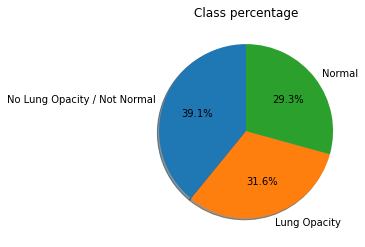

In [21]:
class_info=merged_class_df["class"].value_counts()
labels = (np.array(class_info.index))
sizes = (np.array((class_info / class_info.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Class percentage")
plt.show()

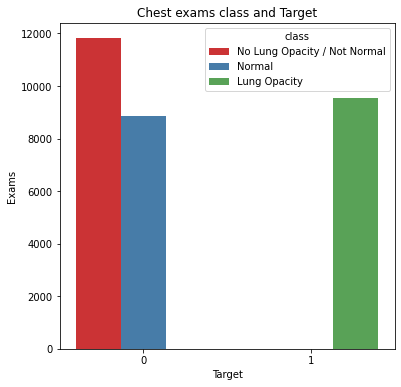

In [22]:
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
tmp = merged_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set1')
plt.title("Chest exams class and Target")
plt.show()

In [23]:
# Extract one image and process the DICOM information.
patientId = det_class_info_df.iloc[0]['patientId']
dicom_file_dataset = dcm.read_file(data_path + '/' + 'stage_2_train_images' + '/' + patientId + '.dcm' )

In [24]:
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

## Filter Data

In [25]:
def filterPatientsByCriteria(criterion):
    x = 1
    for key in criterion.keys():
      if (x==1):
        filt_class_df = det_class_info_df[det_class_info_df['class']==key].sample(int(criterion.get(key)))
      else:
        filt_class_df=filt_class_df.append(det_class_info_df[det_class_info_df['class']==key].sample(int(criterion.get(key))))
      x = x + 1
    return filt_class_df

In [26]:
def generateAugmentationList(filt_class_df, augm_count):
  rowlist=[]
  augm_data=[]
  for i in range(augm_count):
    exists=True 
    while exists:
      n=random.randint(0,filt_class_df.shape[0]-1)
      if n in rowlist:
        exists=True
      else:
        rowlist.append(n)
        row = filt_class_df.iloc[n]
        augm_data.append(['xxx ' + row['patientId'], row['class'], row['Target'], 'aug'])
        exists=False
  filt_class_df=filt_class_df.append(pd.DataFrame(augm_data, 
               columns=[ 'patientId', 'class', 'Target', 'row_type']),
               ignore_index = True)
  return filt_class_df

In [27]:
def get_filtered_data_criterion(criterion, aug_count):
  filt_class_df = pd.DataFrame()
  if not os.path.exists(data_path + '/' + 'filtered_data_aug.csv'):
    # Filter data based on the criterion
    filt_class_df = filterPatientsByCriteria(criterion)
    # Dropping the checksum from the filtered dataset as it is not relevant
    filt_class_df.drop(['checksum'], axis=1, inplace=True)
    # Add a new column with default value of 'orig'. The augmented row will have row_type = 'aug'
    filt_class_df['row_type'] = 'orig'
    # Append the augmented rows to the list
    filt_class_df=generateAugmentationList(filt_class_df, aug_count) # Augmenting 3000 images from the filtered list
    filt_class_df=shuffle(filt_class_df)
    filt_class_df.reset_index(drop=True)
    # Export the data to CSV
    filt_class_df.to_csv(data_path + '/' + 'filtered_data_aug.csv')
  else:
    filt_class_df = pd.read_csv(data_path + '/' + 'filtered_data_aug.csv')
  return filt_class_df

In [28]:
# Set the criterion = {} to load all data
criterion={'Lung Opacity':3000, 
           'No Lung Opacity / Not Normal': 400, 
           'Normal': 400}

In [29]:
filt_class_df = pd.DataFrame()
filt_class_df =  get_filtered_data_criterion(criterion, 3000)

In [30]:
filt_class_df.head()

Unnamed: 0                                 patientId  ... Target  row_type
0         743      1d1c51b5-1cc9-4d0c-8073-5f1cfd598f76  ...      1      orig
1         699      66c52ba5-c91d-4f0c-af96-18148fd9dd66  ...      1      orig
2        4447  xxx 2a55f0bc-4943-4473-8f08-5c0a36fdc929  ...      0       aug
3         382      3862449a-cc8b-40da-91a0-a1437618e65c  ...      1      orig
4        3671      b4bd9d9f-9dee-47f0-a734-afbfb0e554cf  ...      0      orig

[5 rows x 5 columns]

In [31]:
def filterTestPatientsByCriteria(criterion):
    x = 1
    # Create a list of patients that are not in training dataset
    delta_df = det_class_info_df[~det_class_info_df.patientId.isin(filt_class_df.patientId)]
    for key in criterion.keys():
      if (x==1):
        filt_test_class_df = delta_df[delta_df['class']==key].sample(int(criterion.get(key)))
      else:
        filt_test_class_df=filt_test_class_df.append(delta_df[delta_df['class']==key].sample(int(criterion.get(key))))
      x = x + 1
    return filt_test_class_df

In [32]:
# Criteria for loading test data
criterion={'Lung Opacity':300, 
           'No Lung Opacity / Not Normal': 25, 
           'Normal': 25}

In [33]:
filt_test_class_df = pd.DataFrame()
if not os.path.exists(data_path + '/' + 'filtered_test_data.csv'):
  filt_test_class_df =  filterTestPatientsByCriteria(criterion)
  filt_test_class_df.to_csv(data_path + '/' + 'filtered_test_data.csv')
else:
  filt_test_class_df = pd.read_csv(data_path + '/' + 'filtered_test_data.csv', index_col=[0])

In [34]:
filt_test_class_df.reset_index(drop=True)

patientId  ...                          checksum
0    b3cbe758-859f-4ace-8968-4953ca48dfc7  ...  474c09e4986ecec79ae9ceb76c1b9c7d
1    9cf3c0e7-f25c-4358-b5a9-aca2e0b6f33e  ...  c5a4dd680862fecf5a31952edf6f697a
2    fff0b503-72a5-446a-843d-f3d152e39053  ...  2ecae1e26cacd4fed15d7d818f4958ba
3    e0cc9552-af6e-4b2e-8744-78689b0f2aaf  ...  40262a87f2c8484b7ef44c6718d645da
4    af335d18-feec-4942-9831-3e25ca20e7e3  ...  4eac80b41339e8233b88e61429a35532
..                                    ...  ...                               ...
345  8214be18-4b1c-4042-a3f9-c1929c516ffb  ...  78f529648b421ca121968d3bf3401e61
346  9213dc17-1267-42a4-a71d-546a4d994a4a  ...  6c69493495a1691fac282eb5204e8f86
347  9709cc26-3db4-4fc4-a026-2deb53cc5bda  ...  75c3db6bba4f099e41e6d3f2a3689e37
348  35ce8c4b-7dbc-49ae-b141-ee593aa2180e  ...  efb5fa60459d068262ab5b1b2a339cf5
349  aa8377bb-0c43-4c48-b185-bf96cc5c6537  ...  31c1073ec18e725862e8003903b24df8

[350 rows x 4 columns]

## Augment Data

In [35]:
def getBoundingBox(patientId, shape):
  bbs=[]
  for idx_a, row in merged_class_df[(merged_class_df['patientId']==patientId)].iterrows():
    bbs.append(BoundingBox(x1=row['x'], y1=row['y'], x2=row['x']+row['width'], y2=row['y']+row['height']))
  return BoundingBoxesOnImage(bbs, shape=shape)

In [36]:
def getImage(patientId):
  dcm_img = dcm.read_file(data_path +'/' + 'stage_2_train_images' + '/' + patientId + '.dcm').pixel_array
  return dcm_img

In [37]:
def filter_augment_generator(merged_class_df):
  image_array=[]
  merge_aug_data=[]
  m = 0
  count = 200
  for idx, row in filt_class_df.iterrows():
    m += 1
    if row['row_type']=='orig':
      orig_img=getImage(row['patientId'])
      image_array.append(orig_img)
    else:
      aug_image, aug_bbs = augment(row['patientId'][4: :], row['Target'])
      image_array.append(aug_image)
      if row['Target']==1:
        for i in range(len(aug_bbs.bounding_boxes)):
          aug_bb = aug_bbs.bounding_boxes[i]
          x, y, width, height = aug_bb.x1, aug_bb.y1, aug_bb.x2-aug_bb.x1, aug_bb.y2-aug_bb.y1
          merge_aug_data.append([row['patientId'], x, y, width, height, row['Target'], row['class']])
      else:
        merge_aug_data.append([row['patientId'], np.nan, np.nan, np.nan, np.nan, row['Target'], row['class']])
    if m%count == 0:
      print (str(m))
  merged_class_df=merged_class_df.append(pd.DataFrame(merge_aug_data, 
              columns=[ 'patientId', 'x', 'y', 'width', 'height', 'Target', 'class']),
              ignore_index = True)
  return merged_class_df, np.array(image_array)

In [38]:
def load_filtered_augmented_images(merged_class_df):
  orig_aug_array=[]
  if not os.path.exists(data_path + '/' + 'filtered_image_array_aug_orig.npz'):
    merged_class_df, orig_aug_array = filter_and_augment(merged_class_df)
    np.savez_compressed(data_path + '/' + 'filtered_image_array_aug_orig.npz', images=orig_aug_array)
    merged_class_df.to_csv(data_path + '/' + 'merged_data_aug.csv')
  else:
    orig_aug_array = np.load(data_path + '/' + 'filtered_image_array_aug_orig.npz', allow_pickle=True)['images']
    if os.path.exists(data_path + '/' + 'merged_data_aug.csv'):
      merged_class_df = pd.read_csv(data_path + '/' + 'merged_data_aug.csv')
  return merged_class_df, orig_aug_array

In [39]:
orig_aug_array=[]
merged_class_df, orig_aug_array = load_filtered_augmented_images(merged_class_df)

In [40]:
orig_aug_array.shape

(6800, 1024, 1024)

In [41]:
merged_class_df.tail()

Unnamed: 0  ... checksum
34643       34643  ...      NaN
34644       34644  ...      NaN
34645       34645  ...      NaN
34646       34646  ...      NaN
34647       34647  ...      NaN

[5 rows x 9 columns]

Loading Test Images

In [42]:
def loadTestImages():
  test_image_array=[]
  for idx, row in filt_test_class_df.iterrows():
    test_image_array.append(getImage(row['patientId']))
  return np.array(test_image_array)

In [43]:
test_orig_array=[]
if not os.path.exists(data_path + '/' + 'filtered_image_test_orig.npz'):
  test_orig_array=loadTestImages()
  np.savez_compressed(data_path + '/' + 'filtered_image_test_orig.npz', images=test_orig_array)
else:
  test_orig_array = np.load(data_path + '/' + 'filtered_image_test_orig.npz', allow_pickle=True)['images']

In [44]:
test_orig_array.shape

(350, 1024, 1024)

## Resize Images

In [45]:
orig_img_size=1024
do_not_resize=True
target_img_size=256
target_mask_size=int(target_img_size/2)

In [46]:
def resizeMask(idx, imgShape):
  res_mask=np.zeros(imgShape)
  patientId = filt_class_df.iloc[idx]['patientId']
  for idx_a, row_a in merged_class_df[(merged_class_df['patientId']==patientId) & (merged_class_df['Target']==1)].iterrows():
    res_mask[int(row_a['y']):int(row_a['y'])+ int(row_a['height']), 
        int(row_a['x']): int(row_a['x']) + int(row_a['width'])] = 1
  res_mask = resize(res_mask, (target_mask_size, target_mask_size), mode='symmetric')
  return res_mask

In [47]:
# Convert each file
def resizeImage(idx):
    try:
        res_array = resize(orig_aug_array[idx], (target_img_size, target_img_size), mode='symmetric')
    except Exception as e:
        print(file)
        print(e)
    return res_array

In [48]:
# Convert all files within a folder
IST=pytz.timezone('Asia/Kolkata')
def resizeImages():
    res_array=[]
    cnt=filt_class_df.shape[0]
    print('Resizing', str(cnt), 'files from size - 1024x1024 to', str(target_img_size) + 'x' + str(target_img_size))
    print ('-----------------------------------------------------')
    current_time = datetime.datetime.now(IST).strftime("%H:%M:%S")
    print("Start Time =", current_time)
    for idx in range(cnt):
      ia = resizeImage(idx)
      res_array.append(ia)
    current_time = datetime.datetime.now(IST).strftime("%H:%M:%S")
    print("End Time =", current_time)
    return np.array(res_array)    

In [49]:
#Loading resized image array. 
#If pneumonia_data_orig_aug_res_<>.npz doesn't exist, then resize first and save it 
def load_image():
  resized_array=[]
  if not os.path.exists(data_path + '/' + 'pneumonia_data_orig_aug_res_' + str(target_img_size) + '.npz'):
    resized_array = resizeImages()
    np.savez_compressed(data_path + '/' + 'pneumonia_data_orig_aug_res_' + str(target_img_size) + '.npz', images=resized_array)
  else:
    resized_array = np.load(data_path + '/' + 'pneumonia_data_orig_aug_res_' + str(target_img_size) + '.npz', allow_pickle=True)['images']
  return resized_array

In [50]:
resized_array=[]
if do_not_resize:
  resized_array=orig_aug_array
else:
  resized_array = load_image()
  del orig_aug_array

In [51]:
print(resized_array.shape)

(6800, 1024, 1024)


Resize test images

In [52]:
def load_test_images():
  resized_test_array=[]
  if not os.path.exists(data_path + '/' + 'pneumonia_data_orig_test_' + str(target_img_size) + '.npz'):
    cnt=filt_test_class_df.shape[0]
    for idx in range(cnt):
      ia = resize(test_orig_array[idx], (target_img_size, target_img_size), mode='symmetric')
      resized_test_array.append(ia)
    np.savez_compressed(data_path + '/' + 'pneumonia_data_orig_test_' + str(target_img_size) + '.npz', images=resized_test_array)
  else:
    resized_test_array = np.load(data_path + '/' + 'pneumonia_data_orig_test_' + str(target_img_size) + '.npz', allow_pickle=True)['images']
  return np.array(resized_test_array)

In [53]:
if do_not_resize:
  resized_test_array=test_orig_array
else:
  resized_test_array=load_test_images()
  del test_orig_array

In [54]:
print(resized_test_array.shape)

(350, 1024, 1024)


Defining function for plotting images

In [55]:
# This function is to validate the JPG display against the original
def plot_dcm_images(ax, patientId, c, bb_box=False):
  dcm_data = dcm.read_file(data_path +'/' + 'stage_2_train_images/' + patientId + '.dcm')
  ax[c//3, c%3].imshow(dcm_data.pixel_array, cmap=plt.cm.bone)
  ax[c//3, c%3].set_title('ID: {}\n'.format(patientId))
  if bb_box:
    for idx, row in merged_class_df[merged_class_df['patientId']==patientId].iterrows():
      ax[c//3, c%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                                        width=row['width'],height=row['height'],
                                        linewidth=1, edgecolor='r', facecolor='none'))

In [56]:
# Pass bb_box as True for target 1 to draw bounding boxes
def plot_images(ax, patientId, c, bb_box=False, col=3):
  idx=np.where(filt_class_df['patientId']==patientId)
  if do_not_resize:
    target_img_size = orig_img_size
  scale=target_img_size/orig_img_size
  ax[c//col, c%col].imshow(resized_array[idx].reshape(target_img_size, target_img_size), cmap=plt.cm.bone)
  ax[c//col, c%col].set_title('ID: {}\n'.format(patientId))
  if bb_box:
    for idx, row in merged_class_df[merged_class_df['patientId']==patientId].iterrows():
      ax[c//col, c%col].add_patch(Rectangle(xy=(row['x']*scale, row['y']*scale),
                 width=row['width']*scale,height=row['height']*scale,
                 linewidth=2, edgecolor="white",fill=False))

Plot images with bounding boxes of subjects that were detected with Pneumonia

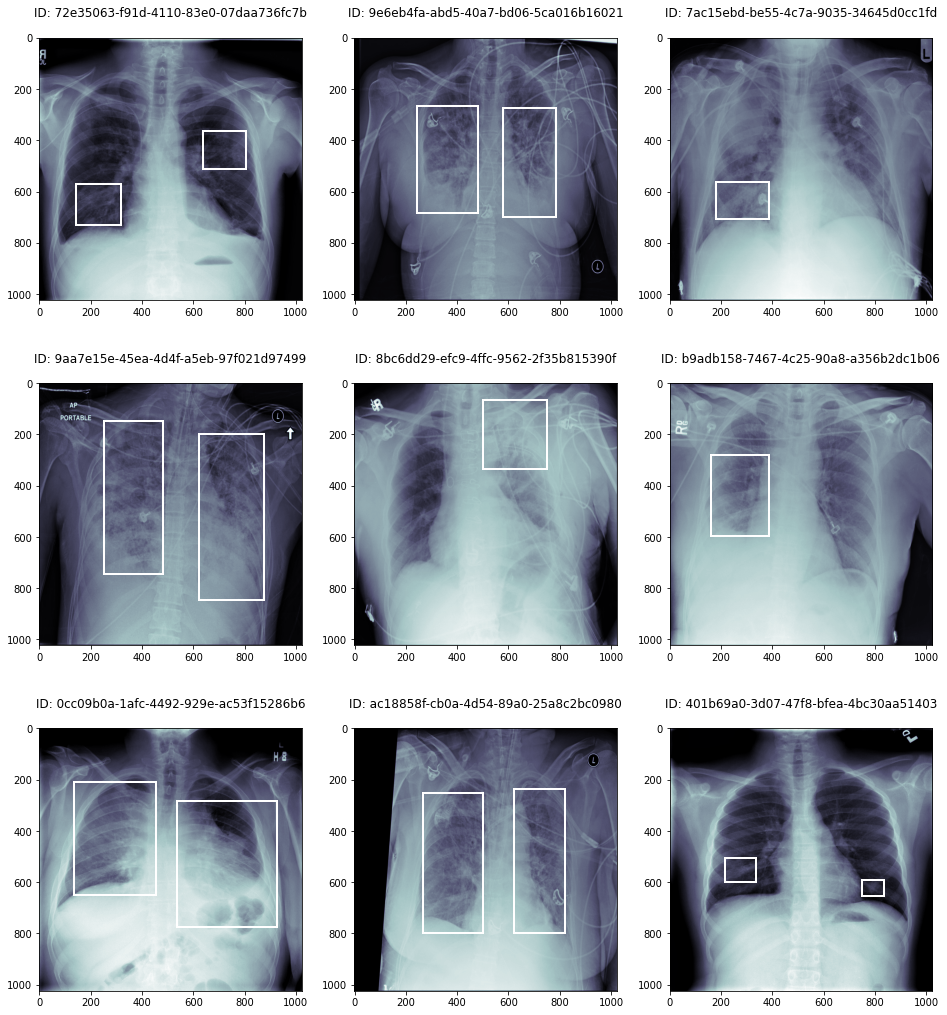

In [57]:
c = 0
f, ax = plt.subplots(3,3, figsize=(16,18))
# Array for storing the ids that can be used to display DCM 
image_ids=[]
# Target = 1
for patientId in filt_class_df[(filt_class_df['Target']==1) & (filt_class_df['patientId'].str.startswith('xxx ')==False)].patientId.sample(9):
  image_ids.append(patientId)
  plot_images (ax, patientId, c, True)
  c = c + 1

Plot DCM images

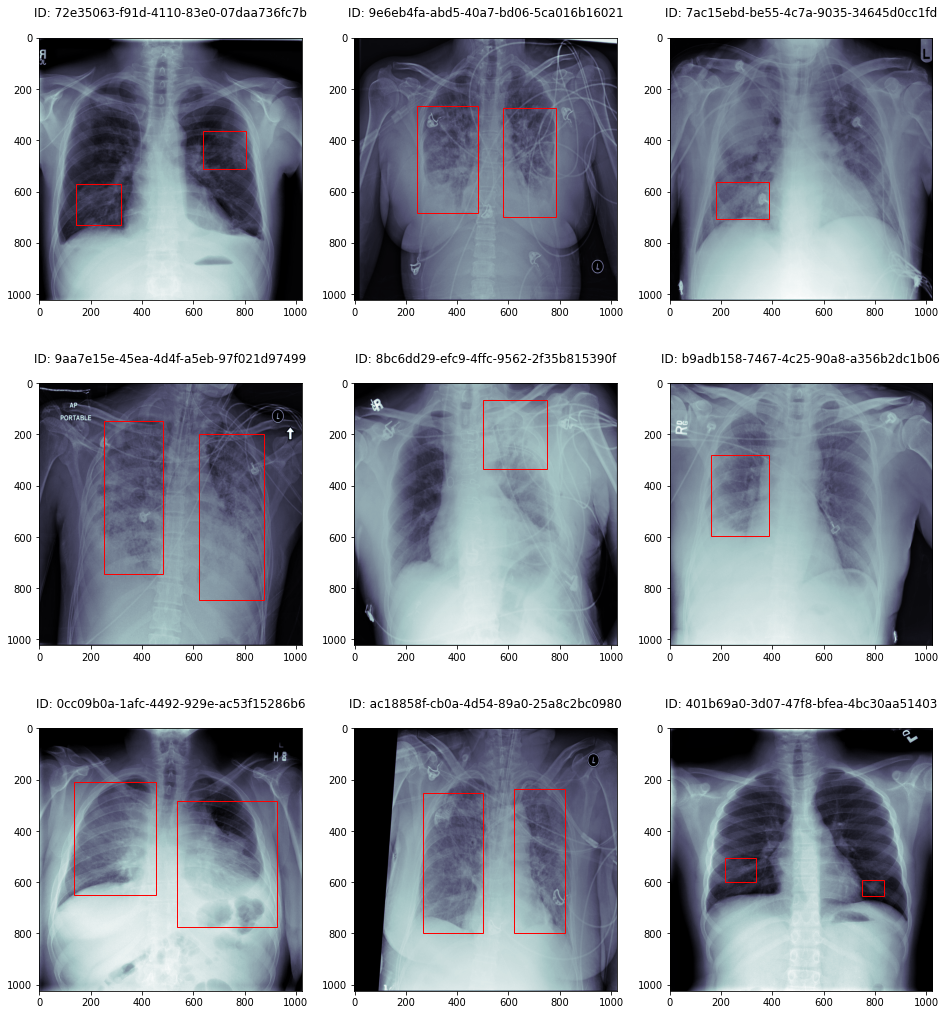

In [58]:
c = 0
f, ax = plt.subplots(3,3, figsize=(16,18))
# Target = 1
for patientId in image_ids:
  plot_dcm_images (ax, patientId, c, True)
  c = c + 1

Plot images of subjects with no Pneumonia

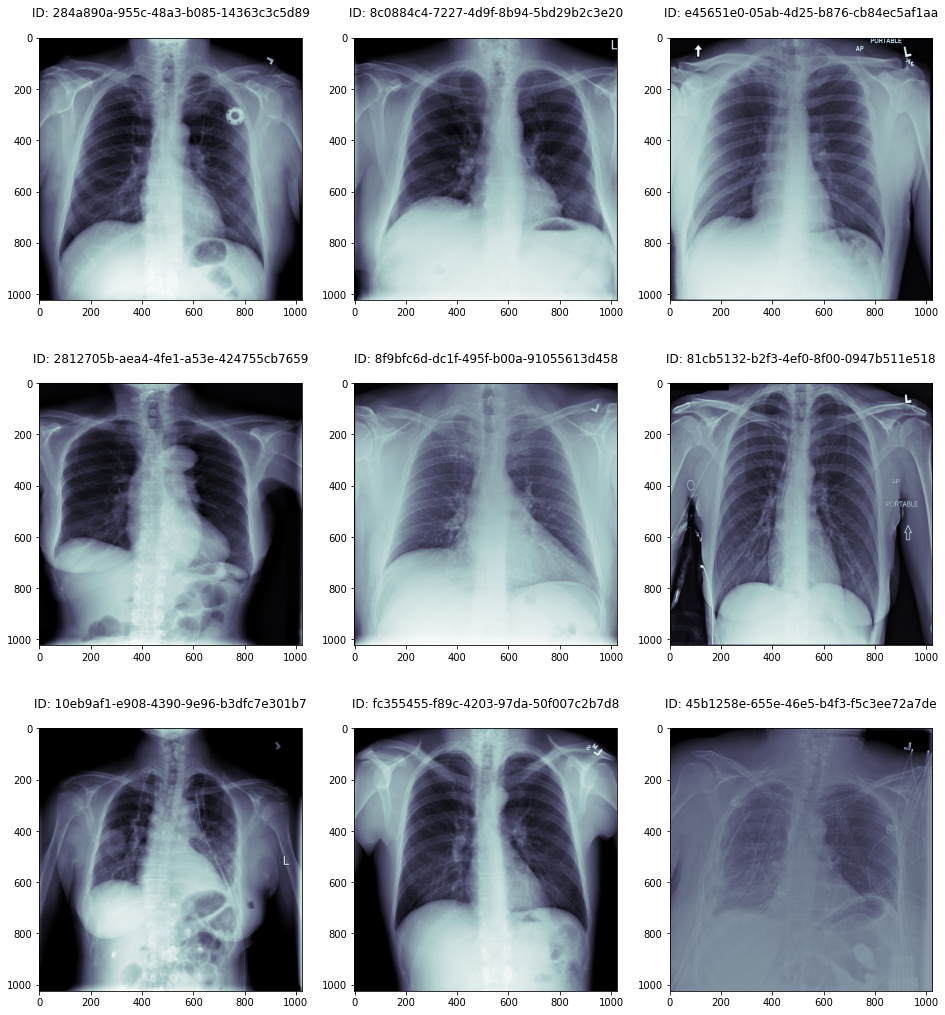

In [59]:
c = 0
f, ax = plt.subplots(3,3, figsize=(16,18))
# Array for storing the ids that can be used to display DCM 
image_ids1=[]
# Target = 0
for patientId in filt_class_df[(filt_class_df['Target']==0) & (filt_class_df['patientId'].str.startswith('xxx ')==False)].patientId.sample(9):
  image_ids1.append(patientId)
  plot_images (ax, patientId, c, False)
  c = c + 1

Plot augmented images side by side with original

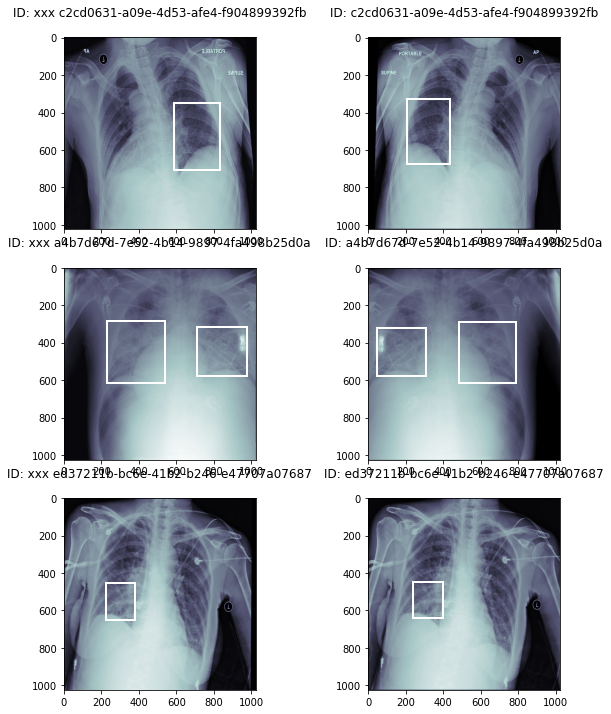

In [65]:
c = 0
f, ax = plt.subplots(3,2, figsize=(10,12))
for patientId in filt_class_df[(filt_class_df['Target']==1) & (filt_class_df['patientId'].str.startswith('xxx ')==True)].patientId.sample(3):
  plot_images (ax, patientId, c, True, 2)
  c = c + 1
  patientId = patientId[4::]
  plot_images (ax, patientId, c, True, 2)
  c = c + 1  

Plot masks for subjects with Pneumonia

In [66]:
def getMask(patientId, imgShape):
  image_mask=np.zeros(imgShape)
  if do_not_resize:
    target_mask_size=orig_img_size
  for idx_a, row_a in merged_class_df[(merged_class_df['patientId']==patientId) & (merged_class_df['Target']==1)].iterrows():
    image_mask[int(row_a['y']):int(row_a['y'])+ int(row_a['height']), 
        int(row_a['x']): int(row_a['x']) + int(row_a['width'])] = 1
  image_mask = resize(image_mask, (target_mask_size, target_mask_size), mode='symmetric')
  return image_mask

In [67]:
# Pass bb_box as True for target 1 to draw bounding boxes
def plot_masks(filt_df, ax, patientId, c, bb_box=False):
  idx=np.where(filt_df['patientId']==patientId)
  ax[c//3, c%3].imshow(getMask(patientId, (1024, 1024)))
  ax[c//3, c%3].set_title('ID: {}\n'.format(patientId))

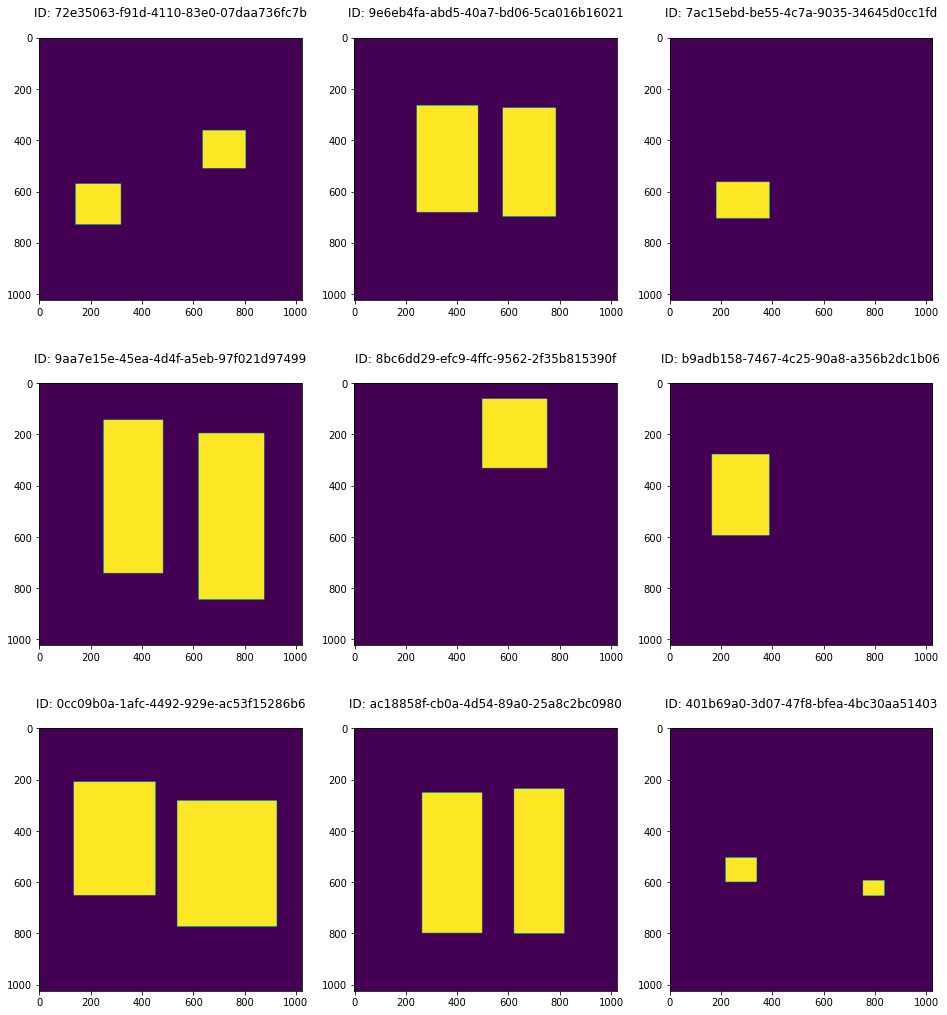

In [68]:
c = 0
f, ax = plt.subplots(3,3, figsize=(16,18))
# Target = 1
for patientId in image_ids:
  plot_masks (filt_class_df, ax, patientId, c, True)
  c = c + 1

#MaskRCNN

In [ ]:
ROOT_DIR=data_path
import sys, math
sys.path.append(os.path.join(data_path, 'Mask_RCNN'))

In [ ]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
importlib.reload(modellib)

<module 'mrcnn.model' from '/content/drive/MyDrive/Colab/Capstone Project/dataset/Mask_RCNN/mrcnn/model.py'>

In [ ]:
class MaskRCnnConfig(Config):
    NAME = 'MaskRCNN'
    TRAINING_WEIGHTS='mask_rcnn_coco.h5'
    TESTING_WEIGHTS=''
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2
    ORIG_IMAGE_SHAPE=(1024, 1024)
#    MASK_SHAPE=(28, 28)
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 4
    DETECTION_MIN_CONFIDENCE = 0.78
    DETECTION_NMS_THRESHOLD = 0.01
    STEPS_PER_EPOCH = 200
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    USE_MINI_MASK=True

In [ ]:
class InferenceConfig(MaskRCnnConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [ ]:
class MaskDataset(utils.Dataset):
    def __init__(self, image_fps, image_annotations, config, image_array):
        super().__init__(self)
        # Add classes
        self.config=config
        self.image_array=image_array
        self.image_annotations = image_annotations
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, patiendId in enumerate(image_fps):
            annotations = self.image_annotations[patiendId]
            self.add_image('pneumonia', image_id=i, annotations=annotations, image_height=self.config.ORIG_IMAGE_SHAPE[0], image_width=self.config.ORIG_IMAGE_SHAPE[1])

    def add_image(self, source, image_id, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)


    def load_image(self, image_id):
        image = self.image_array[image_id]
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image


    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['image_height'], info['image_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['image_height'], info['image_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [ ]:
def get_patient_list(data_df):
    return data_df['patientId'].tolist()

image_annotations={}

def parse_dataset(labels, data_df): 
    image_list = get_patient_list(data_df)
    image_annotations = {p: [] for p in image_list}
    for patientId in image_list:
      for index, row in merged_class_df[merged_class_df['patientId']==patientId][['x', 'y', 'width', 'height', 'Target']].iterrows(): 
        image_annotations[patientId].append(row)
    return image_list, image_annotations 

Variable initialization

In [ ]:
# Dictionary of results keyed by id.
model_results={}
# Dictionary of checkpoint directories keyed by id.
cp_dir={}
# Training models keyed by id.
model_list={}
# Testing models keyed by id.
infer_model_list={}
# Track epoch
epoch_list={}

Parse training and validation dataset

In [ ]:
image_list, image_annotations = parse_dataset(labels_df, filt_class_df)

Parse test dataset

In [ ]:
test_image_list, test_image_annotations=parse_dataset(labels_df, filt_test_class_df)

##Define Model & Functions

In [ ]:
mask_config = MaskRCnnConfig()
mask_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        4
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
maskrcnn_infer_config = InferenceConfig()
maskrcnn_infer_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        4
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
def create_maskmodel():
  model = modellib.MaskRCNN(mode='training', config=mask_config, model_dir=ROOT_DIR)
  weights_path = data_path + '/' + 'Mask_RCNN' + '/' + mask_config.TRAINING_WEIGHTS
  # Exclude the last layers because they require a matching
  # number of classes
  model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", 
                                                          "mrcnn_bbox_fc", 
                                                          "mrcnn_bbox", 
                                                          "mrcnn_mask"])
  return model

In [ ]:
def create_infernce_maskmodel(model_path, infer_config):

  # Recreate the model in inference mode
  model = modellib.MaskRCNN(mode='inference', 
                            config=infer_config,
                            model_dir=ROOT_DIR)

  model.load_weights(model_path, by_name=True)
  return model

In [ ]:
def get_epoch_with_min_loss(id, loss):
  return model_results[id][model_results[id][loss]==model_results[id][loss].min()]

In [ ]:
def plot_loss_graph(id):
  plt.figure(figsize=(17,5))

  plt.subplot(131)
  plt.plot(model_results[id].index, model_results[id]["loss"], label="Train loss")
  plt.plot(model_results[id].index, model_results[id]["val_loss"], label="Valid loss")
  plt.legend()
  plt.subplot(132)
  plt.plot(model_results[id].index, model_results[id]["mrcnn_class_loss"], label="Train class loss")
  plt.plot(model_results[id].index, model_results[id]["val_mrcnn_class_loss"], label="Valid class loss")
  plt.legend()
  plt.subplot(133)
  plt.plot(model_results[id].index, model_results[id]["mrcnn_bbox_loss"], label="Train box loss")
  plt.plot(model_results[id].index, model_results[id]["val_mrcnn_bbox_loss"], label="Valid box loss")
  plt.legend()
  plt.show()

## Split data into training and validation

In [ ]:
random.seed(0)
X_train, X_val = train_test_split(image_list, test_size=0.15)

Prepare training dataset

In [ ]:
dataset_train = MaskDataset(X_train, image_annotations, mask_config, resized_array)
dataset_train.prepare()

Prepare validation dataset

In [ ]:
dataset_val = MaskDataset(X_val, image_annotations, mask_config, resized_array)
dataset_val.prepare()

Prepare test dataset

In [ ]:
dataset_test = MaskDataset(test_image_list, test_image_annotations, maskrcnn_infer_config, resized_test_array)
dataset_test.prepare()

##Iteration 1: Determine the best learning rate using LRFinder

In [ ]:
model= create_maskmodel()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [ ]:
MIN_LR=1e-6
MAX_LR=1e-1
lr_callback = LRFinder(min_lr=MIN_LR, max_lr=MAX_LR)


Starting at epoch 0. LR=0.01

Checkpoint Path: /content/drive/MyDrive/Colab/Capstone Project/dataset/maskrcnn20210521T1915/mask_rcnn_maskrcnn_{epoch:04d}.h5

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None

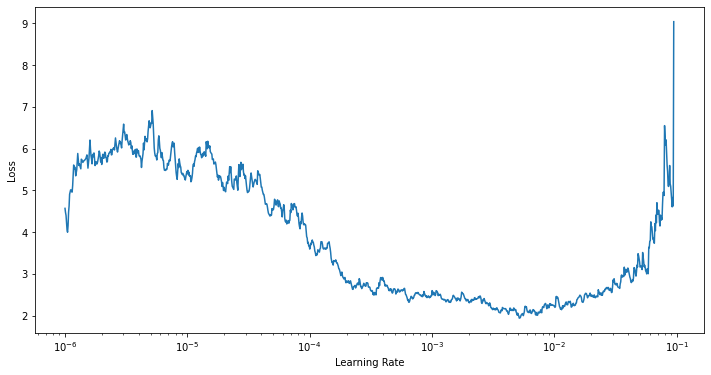

In [ ]:
EPOCHS=30
model.train(dataset_train,
            dataset_val,
            learning_rate=0.01,
            epochs=EPOCHS,
            layers='all',
            augmentation=None,
            custom_callbacks=[lr_callback])  ## no need to augment yet
history = model.keras_model.history.history

Learning rate of 1e-3 to 1e-2 seems to be the best learning rate

##Iteration 2: Run with heads only

In [ ]:
ID='M2'
if ID in model_list:
  model=model_list[ID]
else:
  model_list[ID]=create_maskmodel()
  model=model_list[ID]

In [ ]:
EPOCHS=30
LEARNING_RATE=0.001

In [ ]:
model.train(dataset_train, 
            dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=EPOCHS,
            layers='heads',
            augmentation=None)
history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab/Capstone Project/dataset/maskrcnn20210521T1950/mask_rcnn_maskrcnn_{epoch:04d}.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
model_results[ID]=pd.DataFrame(history, index=epochs)

In [ ]:
model_results[ID]

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
1   2.132485            0.029321  ...         0.649259         0.477706
2   2.061063            0.038514  ...         0.602511         0.458613
3   1.957686            0.023686  ...         0.630209         0.451474
4   2.314151            0.029250  ...         0.585724         0.451027
5   1.967302            0.024622  ...         0.615569         0.465129
6   2.600468            0.028296  ...         0.577673         0.462987
7   2.111880            0.024665  ...         0.537629         0.436379
8   1.853130            0.022158  ...         0.572111         0.448879
9   2.282525            0.034352  ...         0.579331         0.456155
10  2.349592            0.025491  ...         0.554664         0.434442
11  1.988393            0.024030  ...         0.576838         0.449781
12  2.080790            0.030692  ...         0.579613         0.463140
13  2.230271            0.022091  ...         0.588638         0.461495
14  2.137165            0.030343  ...         0.571495         0.457715
15  2.486734            0.033717  ...         0.576419         0.460454
16  1.824206            0.015254  ...         0.541760         0.444009
17  2.208398            0.020514  ...         0.503010         0.444305
18  2.304870            0.025436  ...         0.557164         0.447278
19  2.129234            0.024195  ...         0.549684         0.452846
20  2.048509            0.023863  ...         0.546041         0.456923
21  2.090250            0.025316  ...         0.572809         0.459947
22  2.205367            0.025377  ...         0.561983         0.457175
23  2.208607            0.026488  ...         0.560987         0.450030
24  2.125218            0.023373  ...         0.544294         0.443512
25  2.187885            0.026903  ...         0.531610         0.444591
26  2.108293            0.022696  ...         0.563740         0.451167
27  2.274871            0.022531  ...         0.557833         0.447527
28  1.910317            0.021715  ...         0.542471         0.458807
29  1.976176            0.024194  ...         0.567174         0.453692
30  2.383199            0.025663  ...         0.540417         0.442723

[30 rows x 12 columns]

In [ ]:
best_epoch=get_epoch_with_min_loss(ID, 'val_loss')
epoch_list[ID]=best_epoch.index[0]
best_epoch

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
16  1.824206            0.015254  ...          0.54176         0.444009

[1 rows x 12 columns]

In [ ]:
cp_dir[ID]=model.checkpoint_path.replace(data_path+'/', '').split('/')[0]
cp_dir[ID]

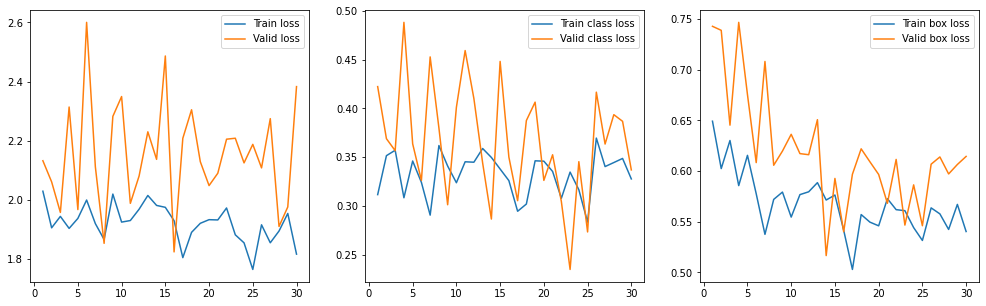

In [ ]:
plot_loss_graph(ID)

##Iteration 3: All layers

In [ ]:
ID='M3'
if ID in model_list:
  model=model_list[ID]
else:
  model_list[ID]=create_maskmodel()
  model=model_list[ID]

In [ ]:
EPOCHS=30
LEARNING_RATE=0.001

In [ ]:
model.train(dataset_train, 
            dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=EPOCHS,
            layers='all',
            augmentation=None)
history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab/Capstone Project/dataset/maskrcnn20210521T2010/mask_rcnn_maskrcnn_{epoch:04d}.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None

In [ ]:
epochs = range(1,len(next(iter(history.values())))+1)
epoch_list[ID]=best_epoch.index[0]
model_results[ID]=pd.DataFrame(history, index=epochs)

In [ ]:
model_results[ID]

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
1   2.097440            0.032500  ...         0.717103         0.492486
2   2.134291            0.032439  ...         0.597647         0.449801
3   3.403372            0.029507  ...         0.593581         0.452333
4   2.076502            0.024797  ...         0.572206         0.455545
5   2.125595            0.027312  ...         0.566438         0.461909
6   2.204927            0.025918  ...         0.552977         0.452951
7   2.073562            0.020908  ...         0.553160         0.448326
8   1.826510            0.016251  ...         0.555357         0.449973
9   1.978923            0.021587  ...         0.544129         0.452359
10  2.309779            0.027936  ...         0.556751         0.466662
11  2.034047            0.026525  ...         0.534380         0.440005
12  1.845390            0.018650  ...         0.530245         0.442209
13  2.332829            0.027054  ...         0.535424         0.442265
14  1.917001            0.019003  ...         0.522937         0.446505
15  2.043315            0.022488  ...         0.536328         0.445798
16  2.099057            0.023466  ...         0.519516         0.446961
17  2.468780            0.030962  ...         0.490714         0.436931
18  2.389945            0.028179  ...         0.546580         0.454678
19  2.203250            0.021344  ...         0.524004         0.434815
20  3.032056            0.037821  ...         0.519496         0.440789
21  2.224797            0.024571  ...         0.528785         0.458406
22  2.028049            0.019727  ...         0.527081         0.439457
23  2.196956            0.030005  ...         0.550422         0.442588
24  2.257794            0.024685  ...         0.510664         0.453156
25  2.211761            0.025907  ...         0.537643         0.448586
26  2.122490            0.025778  ...         0.540883         0.447805
27  2.002381            0.017853  ...         0.550354         0.451088
28  1.874066            0.021397  ...         0.556408         0.445281
29  2.188408            0.023021  ...         0.543994         0.458444
30  2.104131            0.020829  ...         0.563462         0.466950

[30 rows x 12 columns]

In [ ]:
best_epoch=get_epoch_with_min_loss(ID, 'val_loss')
epoch_list[ID]=best_epoch.index[0]
best_epoch

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
8   1.82651            0.016251  ...         0.555357         0.449973

[1 rows x 12 columns]

In [ ]:
cp_dir[ID]=model.checkpoint_path.replace(data_path+'/', '').split('/')[0]
cp_dir[ID]

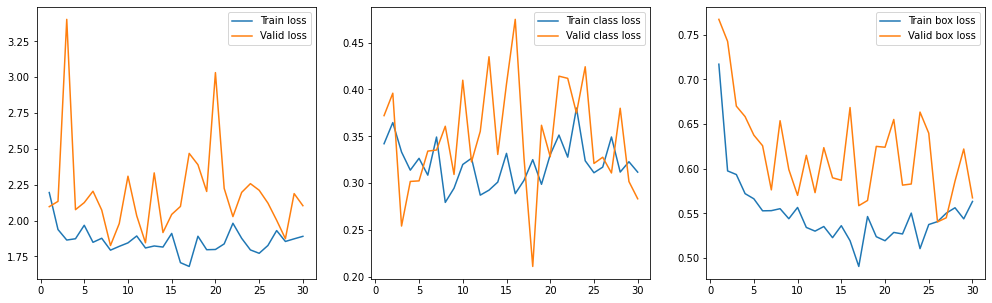

In [ ]:
plot_loss_graph(ID)

In [ ]:
#cp_dir['M2']='maskrcnn20210521T1950'
#epoch_list['M2']=16
#cp_dir['M3']='maskrcnn20210521T2010'
#epoch_list['M3']=8

##Test model by using the best model and relevant weights

In [ ]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [ ]:
def dice_coef(y_true, y_pred):
    intersec = y_true*y_pred
    union = y_true+y_pred
    if intersec.sum() == 0:
        dice_coef = 0
    else:
        dice_coef = round(intersec.sum()*2/union.sum(), 2)
    return dice_coef

In [ ]:
def coeff_per_image(image_id, pred, gt_mask, gt_class_id):
    
    coeff_dict = {}
    for clsid in range(maskrcnn_infer_config.NUM_CLASSES):         
        coeff_dict[clsid] = []
        gt_index = np.where(gt_class_id == clsid)
        
        # if there is no groundtruth or no predicted mask, the coefficient is equal to zero
        if gt_index[0].size ==0 or len(pred['masks']) == 0:
            coeff_dict[clsid].append(0)
        else:
            # get the union of all groundtruth masks belong to clsid
            gt_mask_per_class = gt_mask[:,:,gt_index[0]] # get groundtruth mask
            _gt_sum = np.zeros((gt_mask.shape[0],gt_mask.shape[1]))
            # Iterate through each mash
            for gt_num in range(gt_mask_per_class.shape[2]):
                _gt =  gt_mask_per_class[:,:,gt_num]
                _gt_sum = _gt_sum + _gt
            _gt_union = (_gt_sum>0).astype(int)

            # get the union of all predicted masks belong to clsid
            pred_index = np.where(pred['class_ids'] == clsid)
            pred_mask_per_class = pred['masks'][:,:,pred_index[0]]

            _mask_sum = np.zeros((pred['masks'].shape[0],pred['masks'].shape[1]))

            for num in range(pred_mask_per_class.shape[2]):
                _mask = pred_mask_per_class[:,:,num]
                _mask_sum = _mask_sum + _mask

            _mask_union = (_mask_sum>0).astype(int)
            
            coeff_dict[clsid].append(dice_coef(_mask_union, _gt_union))
    return coeff_dict

In [ ]:
def eval_model(test_with_id, det_conf):
  maskrcnn_infer_config.DETECTION_MIN_CONFIDENCE=det_conf
  model=create_infernce_maskmodel(data_path + '/' + cp_dir[test_with_id] + '/' + 'mask_rcnn_maskrcnn_' + str(epoch_list[test_with_id]).zfill(4)+'.h5', 
                                                 maskrcnn_infer_config)
  fig = plt.figure(figsize=(10, 30))
  j=0
  APs = list()
  precisions_dict = {}
  recall_dict     = {}
  dice_dict = {}
  len=12
  for i in range(0,len):
    image_id = dataset_test.image_ids[i]
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
          modellib.load_image_gt(dataset_test, maskrcnn_infer_config, 
                                image_id, use_mini_mask=False)
    
    plt.subplot(len, 2, 2*j + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                  dataset_test.class_names,
                                  colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    plt.subplot(len, 2, 2*j + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    AP, precisions, recalls, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    precisions_dict[image_id] = np.mean(precisions)
    recall_dict[image_id] = np.mean(recalls)
    APs.append(AP)
    dice_dict[image_id] = coeff_per_image(image_id, r, gt_mask, gt_class_id)
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                  dataset_test.class_names, r['scores'], 
                                  colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    j += 1
  mAP = np.mean(APs)
  return mAP,precisions_dict,recall_dict, dice_dict

Re-starting from epoch 16

*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



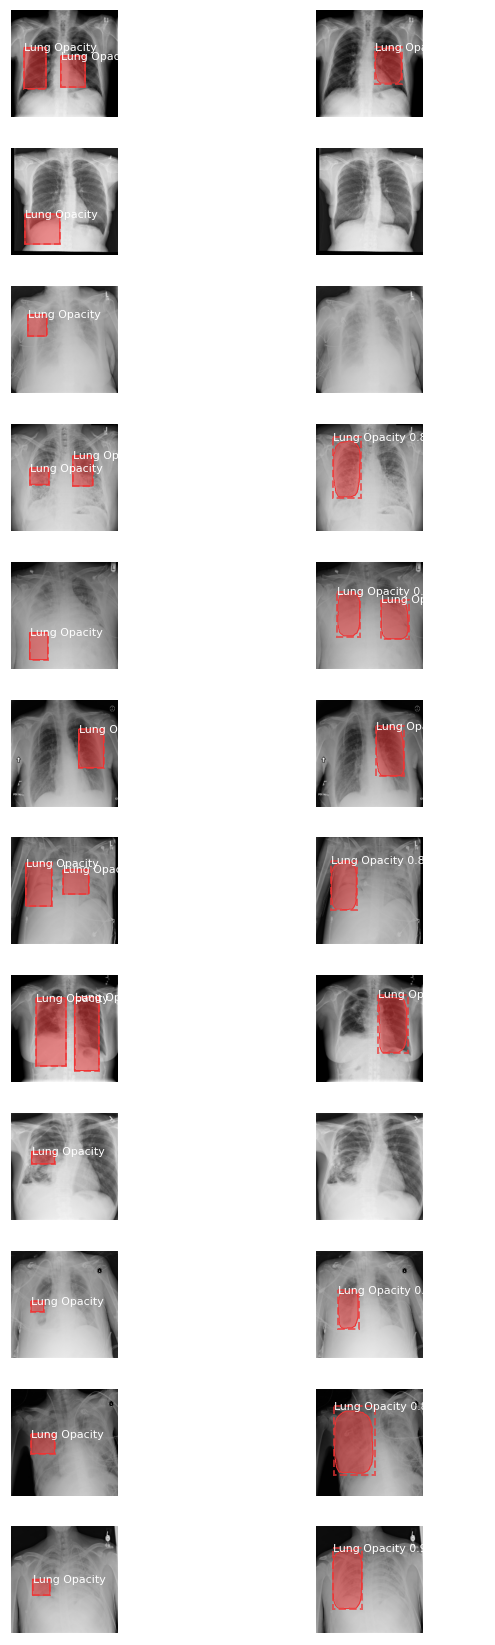

In [ ]:
precision_dict={}
recall_dict={}
dice_dict={}
map, precision_dict, reall_dict, dice_dict = eval_model('M2', 0.85)

In [ ]:
print(dice_dict)

{0: {0: [0], 1: [0.29]}, 1: {0: [0], 1: [0]}, 2: {0: [0], 1: [0]}, 3: {0: [0], 1: [0.28]}, 4: {0: [0], 1: [0.03]}, 5: {0: [0], 1: [0.7]}, 6: {0: [0], 1: [0.71]}, 7: {0: [0], 1: [0.49]}, 8: {0: [0], 1: [0]}, 9: {0: [0], 1: [0.24]}, 10: {0: [0], 1: [0.35]}, 11: {0: [0], 1: [0.3]}}


In [ ]:
print(map)

0.16666666666666666


In [1]:
map, precision_dict, reall_dict, dice_dict = eval_model('M3', 0.85) 

NameError: ignored

In [ ]:
print(map)

0.041666666666666664
